# Lab 4 - Modeling flight delays

A lab done by both:

Kaden Franklin & Ted Bjurlin

From department of transportation

https://hendrix-cs.github.io/csci285/labs/flights.html

In [1]:
# Import pandas
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np

# Import seaborn
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

# Import SciKitLearn functions
from sklearn.datasets import make_blobs, make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import datetime

# Apply the default theme
sns.set_theme()

from tqdm import trange
#progress bar for long running cells

# Step 1: Loading flights

We can retrieve our dataset from:

https://www.kaggle.com/datasets/usdot/flight-delays

https://www.kaggle.com/datasets/hendrixwilsonj/flights-transformed

https://nbviewer.org/github/Hendrix-CS/csci285/blob/master/assets/notebooks/Flight_Delays_And_Cancellations.ipynb?flush_cache=true

In [2]:
air = pd.read_csv("airlines.csv")

air.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [3]:
# Load the transformed data into a data frame called “flights” and familarize yourself with the size and quality of the dataset.

#notably the file is 700+ mb so it will not work inside a git repository, I have chosen to place it in another directory.

flights = pd.read_csv(r"C:\Users\kaden\Documents\files that are too big\flights-transformed.csv")

flights.head()

C:\Users\kaden\AppData\Local\Temp\ipykernel_19512\3203049405.py:5: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  flights = pd.read_csv(r"C:\Users\kaden\Documents\files that are too big\flights-transformed.csv")


,airline,origin_airport,destination_airport,scheduled_time,elapsed_time,scheduled_departure,departure_delay,arrival_delay
0,Alaska Airlines Inc.,Ted Stevens Anchorage International Airport,Seattle-Tacoma International Airport,205.0,194.0,2015-01-01 00:05:00,-11.0,-22.0
1,American Airlines Inc.,Los Angeles International Airport,Palm Beach International Airport,280.0,279.0,2015-01-01 00:10:00,-8.0,-9.0
2,US Airways Inc.,San Francisco International Airport,Charlotte Douglas International Airport,286.0,293.0,2015-01-01 00:20:00,-2.0,5.0
3,American Airlines Inc.,Los Angeles International Airport,Miami International Airport,285.0,281.0,2015-01-01 00:20:00,-5.0,-9.0
4,Alaska Airlines Inc.,Seattle-Tacoma International Airport,Ted Stevens Anchorage International Airport,235.0,215.0,2015-01-01 00:25:00,-1.0,-21.0


In [4]:
print(f"Number of Rows: {len(flights)}")
print(f"Shape (rows x cols): {flights.shape}")

Number of Rows: 5714008
Shape (rows x cols): (5714008, 8)


In [5]:
flights.describe()

,scheduled_time,elapsed_time,departure_delay,arrival_delay
count,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06
mean,1.418940e+02,1.370062e+02,9.294842e+00,4.407057e+00
std,7.531400e+01,7.421107e+01,3.688972e+01,3.927130e+01
min,1.800000e+01,1.400000e+01,-8.200000e+01,-8.700000e+01
25%,8.500000e+01,8.200000e+01,-5.000000e+00,-1.300000e+01
50%,1.230000e+02,1.180000e+02,-2.000000e+00,-5.000000e+00
75%,1.740000e+02,1.680000e+02,7.000000e+00,8.000000e+00
max,7.180000e+02,7.660000e+02,1.988000e+03,1.971000e+03


In [6]:
flights.value_counts(dropna=False)

airline                 origin_airport                                    destination_airport                         scheduled_time  elapsed_time  scheduled_departure  departure_delay  arrival_delay
Southwest Airlines Co.  NaN                                               NaN                                         120.0           106.0         2015-10-06 07:35:00  -5.0             -19.0            2
Delta Air Lines Inc.    NaN                                               NaN                                         166.0           142.0         2015-10-05 10:59:00  -2.0             -26.0            2
Southwest Airlines Co.  NaN                                               NaN                                         90.0            83.0          2015-10-07 06:00:00  -4.0             -11.0            2
                                                                                                                      80.0            75.0          2015-10-14 11:15:00  -2.0            

In [7]:
flights = flights.dropna(subset = flights.columns)

In [8]:
flights.value_counts(dropna=False)

airline                 origin_airport                                    destination_airport                          scheduled_time  elapsed_time  scheduled_departure  departure_delay  arrival_delay
Alaska Airlines Inc.    Adak Airport                                      Ted Stevens Anchorage International Airport  161.0           153.0         2015-09-03 18:00:00   61.0             53.0            1
Southwest Airlines Co.  Cleveland Hopkins International Airport           Baltimore-Washington International Airport   75.0            60.0          2015-03-16 13:40:00   5.0             -10.0            1
                                                                                                                                       61.0          2015-01-05 11:05:00   51.0             37.0            1
                                                                                                                                                     2015-01-03 13:45:00  -3.0       

In [9]:
# Convert scheduled_departure to a datetime (this column loads as a string)
    
flights['scheduled_departure'] = pd.to_datetime(flights['scheduled_departure'])

In [10]:
flights.head()

,airline,origin_airport,destination_airport,scheduled_time,elapsed_time,scheduled_departure,departure_delay,arrival_delay
0,Alaska Airlines Inc.,Ted Stevens Anchorage International Airport,Seattle-Tacoma International Airport,205.0,194.0,2015-01-01 00:05:00,-11.0,-22.0
1,American Airlines Inc.,Los Angeles International Airport,Palm Beach International Airport,280.0,279.0,2015-01-01 00:10:00,-8.0,-9.0
2,US Airways Inc.,San Francisco International Airport,Charlotte Douglas International Airport,286.0,293.0,2015-01-01 00:20:00,-2.0,5.0
3,American Airlines Inc.,Los Angeles International Airport,Miami International Airport,285.0,281.0,2015-01-01 00:20:00,-5.0,-9.0
4,Alaska Airlines Inc.,Seattle-Tacoma International Airport,Ted Stevens Anchorage International Airport,235.0,215.0,2015-01-01 00:25:00,-1.0,-21.0


In [11]:
flights.dtypes
# Write a data dictionary which explains each column’s dtype and meaning.

airline                        object
origin_airport                 object
destination_airport            object
scheduled_time                float64
elapsed_time                  float64
scheduled_departure    datetime64[ns]
departure_delay               float64
arrival_delay                 float64
dtype: object

## Data Dictionary which explains each column’s dtype and meaning

|Feature | DataType | Description|
|:--------|:----------|:------------|
|airline | object | Name of airline|
|origin_airport | object | Airport the flight will take off from|
|destination_airport | object | Airport the flight will land at|
|scheduled_time | float64 | Number describing the scheduled takeoff time |
|elapsed_time | float64 | Number describing the total flight time|
|scheduled_departure | datetime64[ns] | The flight's scheduled takeoff time (*readable*)|
|departure_delay | float64 | Number describing the flight's delay at takeoff|
|arrival_delay | float64 | Number describing the flights delay upon arrival|


# Step 2: Aggregating & Plotting Delay

Let’s start by performing some general analysis about delays. From Flight Delays And Cancellations, we learned that most airlines report delays close to zero but all experience large outliers.

In [12]:
# Using two bar charts aggregated by airline, plot mean departure_delay and mean arrival_delay. 

# Make sure to label your charts, size the figure correctly, and set a title.

new_df = flights.groupby(['airline'], as_index=False).mean(numeric_only=True)

new_df

,airline,scheduled_time,elapsed_time,departure_delay,arrival_delay
0,Alaska Airlines Inc.,181.980385,179.296940,1.892036,-0.791409
1,American Airlines Inc.,172.527060,167.208246,9.254027,3.935214
2,American Eagle Airlines Inc.,96.210442,93.003753,10.523229,7.316540
3,Atlantic Southeast Airlines,99.278895,97.272090,8.971355,6.964550
4,Delta Air Lines Inc.,147.848780,140.822148,7.706897,0.680265
5,Frontier Airlines Inc.,155.737870,155.249765,14.217548,13.729468
6,Hawaiian Airlines Inc.,101.115620,102.780620,0.496856,2.161856
7,JetBlue Airways,173.003866,168.199839,11.753367,6.949339
8,Skywest Airlines Inc.,102.620149,100.729380,8.112207,6.221438
9,Southwest Airlines Co.,127.479958,121.389724,10.928065,4.837831


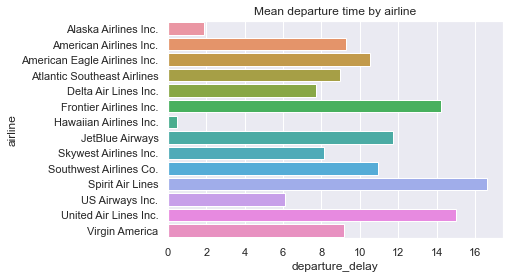

In [13]:
bar = sns.barplot(
    data=new_df, 
    x="departure_delay", 
    y="airline"
).set(
    title="Mean departure time by airline"
)

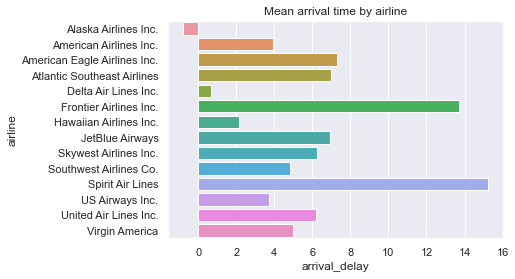

In [14]:
bar = sns.barplot(
    data=new_df, 
    x="arrival_delay", 
    y="airline"
).set(
    title="Mean arrival time by airline"
)

Feature Selection: Restrict columns to just the three mentioned above.

Aggregation: You’ll need to aggregate the data (i.e. mean delays) after feature selection. 

Once aggregation is done, its common to reset the index in order to make the data easier to plot.

In [15]:
newer_df = flights[['airline', 'departure_delay', 'arrival_delay']].groupby(['airline'], as_index=False).mean(numeric_only=True)

Discussion

Examine the charts you just produced. Which airlines are outliers for departure_delay? 


The airline which i an outlier for departure_delay, is Hawaiian Airlines, with a significantly smaller mean departure_delay size.



Which airlines are outliers for arrival_delay? 


Alaskan airlines, and delta airlines. They both produce significantly smaller mean arrival_delay times in comparision to other airlines







Find the mean departure_delay and arrival_delay across all airlines excluding any outliers.

In [16]:
newer_df

,airline,departure_delay,arrival_delay
0,Alaska Airlines Inc.,1.892036,-0.791409
1,American Airlines Inc.,9.254027,3.935214
2,American Eagle Airlines Inc.,10.523229,7.316540
3,Atlantic Southeast Airlines,8.971355,6.964550
4,Delta Air Lines Inc.,7.706897,0.680265
5,Frontier Airlines Inc.,14.217548,13.729468
6,Hawaiian Airlines Inc.,0.496856,2.161856
7,JetBlue Airways,11.753367,6.949339
8,Skywest Airlines Inc.,8.112207,6.221438
9,Southwest Airlines Co.,10.928065,4.837831


In [17]:
newer_df = newer_df.dropna(subset = newer_df.columns).reset_index()

# Step 3: Departure Delay

Now we define some functions needed for later use

In [18]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [19]:
from matplotlib.colors import LinearSegmentedColormap


def plot_heatmap_discrete_legend(data):
    
    # Set the width and height of the figure
    plt.figure(figsize=(20,100))
    
    # Add title
    plt.title("Average Departure Delay (Airline vs. Origin Airport)")
    
    # calc discrete values
    value_to_int = {j:i for i,j in enumerate(pd.unique(data.values.ravel()))}
    n = len(value_to_int)   

    # discrete colormap (n samples from a given cmap)
    cmap = sns.color_palette("Paired", n) 
    ax = sns.heatmap(
        data=data.replace(value_to_int), 
        cmap=cmap,
        linewidths=0.5,
        linecolor='lightgray'
    ) 

    # modify colorbar
    colorbar = ax.collections[0].colorbar 
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
    colorbar.set_ticklabels(list(value_to_int.keys()))                                          
    
    # show plot
    plt.show()

In Step 2, you showed that mean departure_delay is larger than mean arrival_delay

For the rest of this lab, we will continue to model departure_delay, 

but ignore arrival_delay since it may be impacted by variables outside the flights dataset (e.g. flight speed).

In [20]:

# Let’s see if the origin_airport has an impact on departure_delay by plotting a heatmap of 
# airline vs. origin_airport. The color should correspond to delay_level, which we will define in a bit.

# Feature Selection: Start by creating a dataframe that has the three columns mentioned above.

newest_df = flights[['airline', 'origin_airport', 'departure_delay']].groupby(['origin_airport', 'airline']).mean(numeric_only=True)



In [21]:
def delay(deez):
    if deez == np.nan:
        return 'NaN'
    elif deez < 5:
        return 'on time'
    elif deez < 45:
        return 'small delay'
    else:
        return 'long delay'
    

In [22]:
newest_df

departure_delay
origin_airport                  airline                                      
Aberdeen Regional Airport       Skywest Airlines Inc.               10.101056
Abilene Regional Airport        American Eagle Airlines Inc.         5.747647
Abraham Lincoln Capital Airport American Eagle Airlines Inc.         8.846154
                                Atlantic Southeast Airlines          2.878419
                                Skywest Airlines Inc.               12.053459
...                                                                       ...
Yeager Airport                  Delta Air Lines Inc.                 6.273885
                                Skywest Airlines Inc.               14.076923
                                Spirit Air Lines                     7.859375
Yellowstone Regional Airport    Skywest Airlines Inc.                7.204301
Yuma International Airport      Skywest Airlines Inc.                1.232470

[1304 rows x 1 columns]

In [23]:
newest_df['departure_delay'] = [delay(x) for x in newest_df['departure_delay']]

In [24]:
newest_df = newest_df['departure_delay'].unstack()

In [25]:
newest_df

airline,Alaska Airlines Inc.,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America
origin_airport,,,,,,,,,,,,,,
Aberdeen Regional Airport,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,small delay,NaN,NaN,NaN,NaN,NaN
Abilene Regional Airport,NaN,NaN,small delay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abraham Lincoln Capital Airport,NaN,NaN,small delay,on time,NaN,NaN,NaN,NaN,small delay,NaN,NaN,NaN,NaN,NaN
Adak Airport,small delay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Akron-Canton Regional Airport,NaN,NaN,NaN,small delay,small delay,NaN,NaN,NaN,small delay,small delay,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yakutat Airport,on time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yampa Valley Airport (Yampa Valley Regional),NaN,small delay,NaN,small delay,small delay,NaN,NaN,NaN,small delay,NaN,NaN,NaN,small delay,NaN
Yeager Airport,NaN,NaN,NaN,small delay,small delay,NaN,NaN,NaN,small delay,NaN,small delay,NaN,NaN,NaN


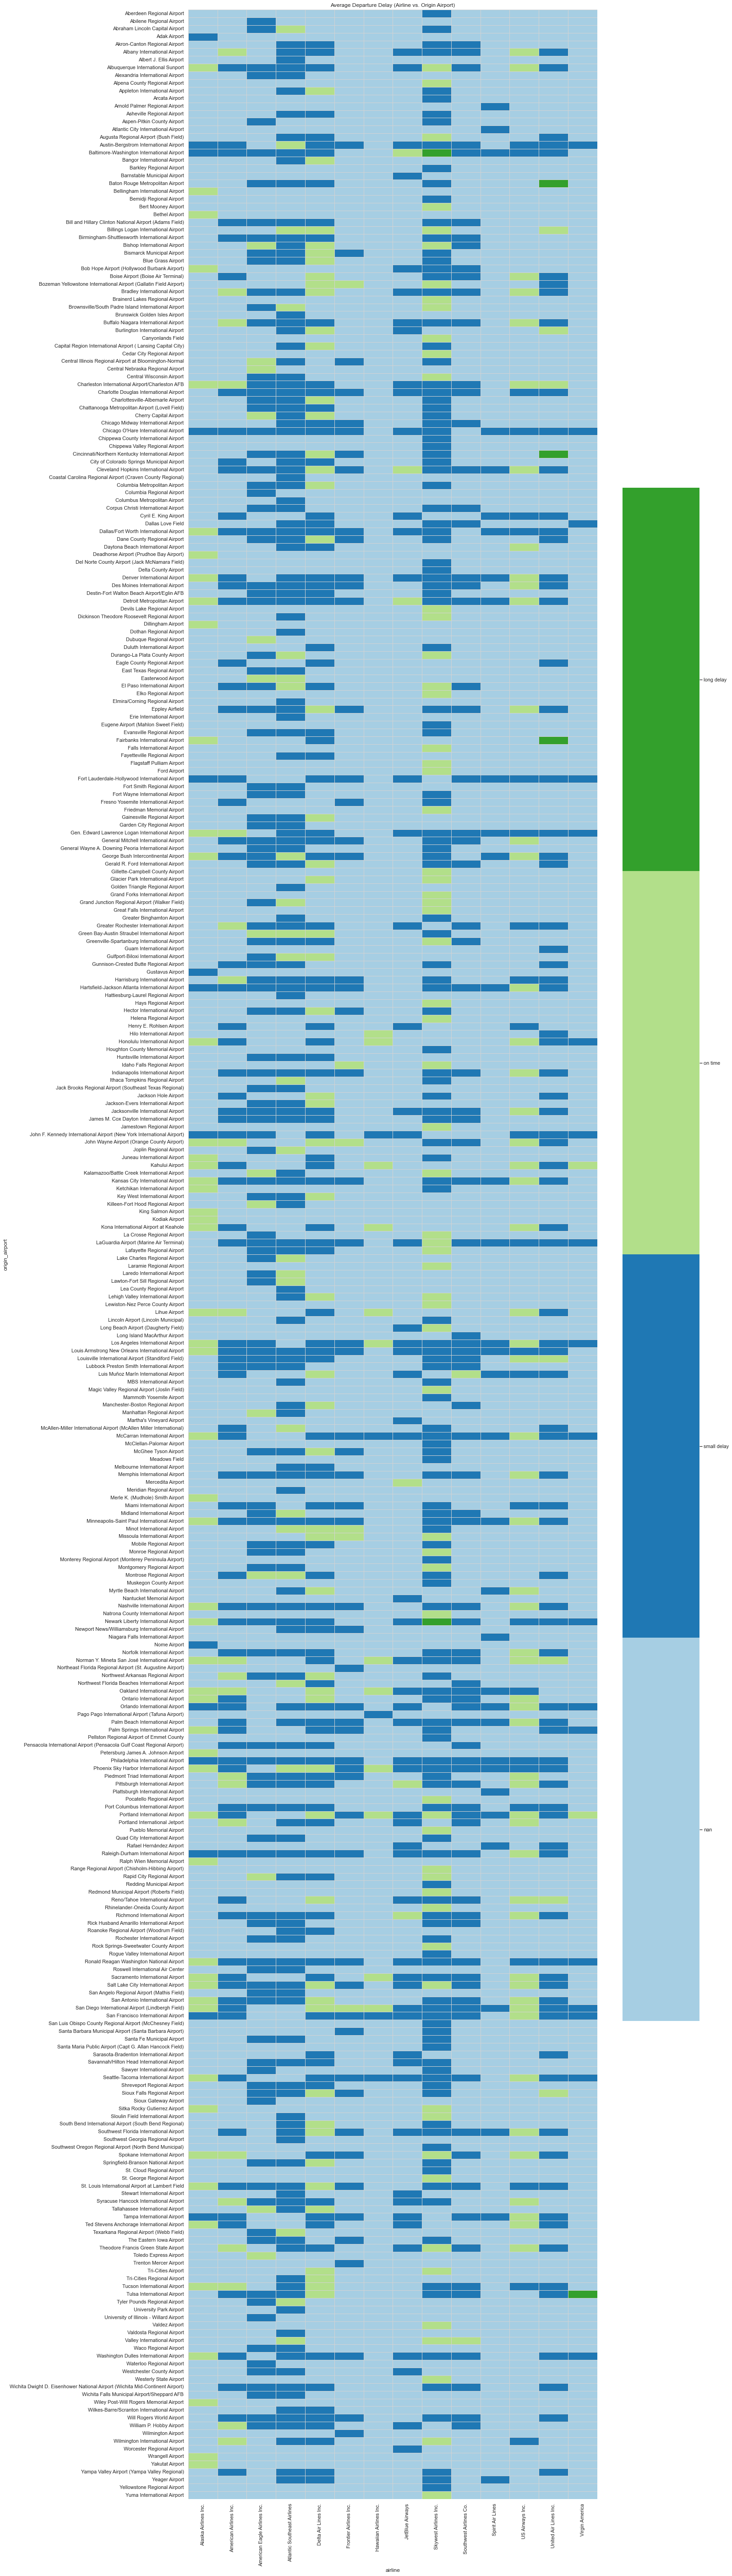

In [26]:
plot_heatmap_discrete_legend(newest_df)

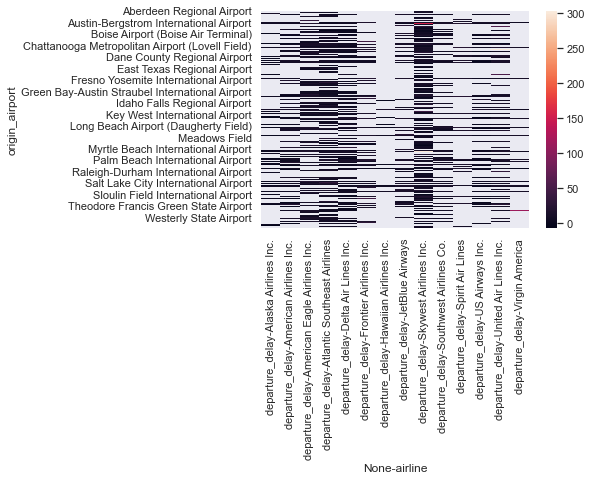

In [27]:
heat = sns.heatmap(
    data = flights[['airline', 'origin_airport', 'departure_delay']].groupby(['origin_airport', 'airline']).mean(numeric_only=True).unstack()
)

Discussion:

Compare the output from using plot_heatmap_discrete_legend() vs. a vanilla call to sns.heatmap. 

The discrete legend heatmap allows us to look at individual airlines and track their punctuality.

The seaborn tries to plot more numeric data, but still gives an overall sense of the delay levels experienced. 
There is realy only one distinct long delay visible on the chart, if you look really hard at the middle center.


What’s the value of discretizing the color pallete and legend?

It allows us to label, and compare relative values with more ease, and at a glance.


Discuss whether origin_airport has an impact on departure_delay. 

It seems as though some of the larger airports report more frequent short delays. This could be due to their size, but it might be better to visualize an airports departure delay without the consideration of airline. That way, you could compare on a case by case basis and compare better.


Are some airports more prone to delays than others? Or is origin_airport not an important feature when modeling flight delays?

As per my questions above, airports reported in physically larger cities report more frequent small delays.

# Part 4: temporal analysis

(For the 15 bonus points)

In [28]:
# Feature Selection: Start by restricting, re-naming, and re-ordering your dataset’s features to the following 
# columns: (airline, airport, time, delay). 
# Here “airport” means origin_airport, “time” means scheduled_departure and “delay” means departure_delay.

temp_df = pd.DataFrame(flights[["airline", "origin_airport", "scheduled_departure", "departure_delay"]])

In [29]:
temp_df.head()

,airline,origin_airport,scheduled_departure,departure_delay
0,Alaska Airlines Inc.,Ted Stevens Anchorage International Airport,2015-01-01 00:05:00,-11.0
1,American Airlines Inc.,Los Angeles International Airport,2015-01-01 00:10:00,-8.0
2,US Airways Inc.,San Francisco International Airport,2015-01-01 00:20:00,-2.0
3,American Airlines Inc.,Los Angeles International Airport,2015-01-01 00:20:00,-5.0
4,Alaska Airlines Inc.,Seattle-Tacoma International Airport,2015-01-01 00:25:00,-1.0


In [30]:
temp_df = temp_df.rename(columns={"airline": "airline", "origin_airport": "airport", "scheduled_departure": "time", "departure_delay": "delay"})

In [31]:
temp_df = temp_df.dropna(subset = temp_df.columns)

In [32]:
temp_df.duplicated().value_counts()

False    5141505
True       89625
dtype: int64

In [33]:
# Aggregation: You’ll need to aggregate the data (i.e. mean delay) after feature selection.
# It is possible for multiple rows to match (airline, airport, time) because destination airport has been dropped
# (i.e. multiple flights can leave at the same time going to different destinations). 
# Check for duplicates before and after aggregating to ensure this was done correctly.

temp_df = temp_df[['airline', 'airport', 'time', 'delay']].groupby(['airline', 'airport', 'time'], as_index=False).mean()


In [34]:
temp_df.duplicated().value_counts()

False    4298403
dtype: int64

In [35]:
delaythreshold = 60 * 12 # delayed less than a day. 

time_range = temp_df['time'] < datetime.datetime(2015, 1, 15)
delay_cap = temp_df['delay'] < delaythreshold
airline = temp_df['airline'] == "American Airlines Inc."
airport = temp_df['airport'] == "Dallas/Fort Worth International Airport"

In [36]:
tempest_df = pd.DataFrame(temp_df[time_range & delay_cap & airline & airport])

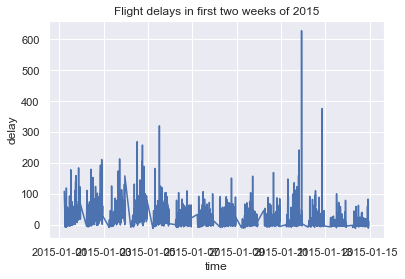

In [37]:
# Plot time vs. delay
# Create two line charts. The first line chart should show data ranging from 2015-01-01 to 2015-01-14. 
# For the second, choose only two or three days of data to display. Make sure to label your axes and set a title.
# Size the figure appropriately. Set aspect=3.0.

line_1 = sns.lineplot(data = tempest_df, x = 'time', y = 'delay').set(
    title = 'Flight delays in first two weeks of 2015'
)

In [38]:
time_range = (tempest_df['time'] <= datetime.datetime(2015, 1, 6)) & (tempest_df['time'] >= datetime.datetime(2015, 1, 3))
tempest_df = tempest_df[time_range]

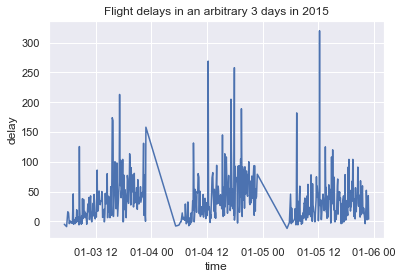

In [39]:
line_2 = sns.lineplot(data = tempest_df, x = 'time', y = 'delay').set(
    title = 'Flight delays in an arbitrary 3 days in 2015'
)

In [40]:
temp_df = temp_df[['time', 'delay']]

In [41]:
def seconds_from_day(day: datetime):
    hours = day.hour
    minutes = (hours * 60) + day.minute
    seconds = (minutes * 60) + day.second
    return seconds

In [42]:
temp_df['time'] = [seconds_from_day(x) for x in temp_df['time']]

In [43]:
temp_df['time'].duplicated().value_counts()

True     4297086
False       1317
Name: time, dtype: int64

In [44]:
temp_df = temp_df.groupby(['time'], as_index= False).mean(numeric_only = True)

In [45]:
temp_df['time'].duplicated().value_counts()

False    1317
Name: time, dtype: int64

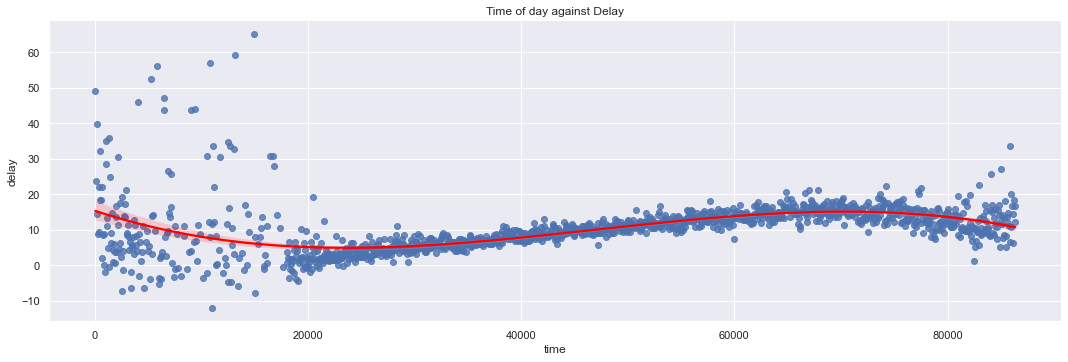

In [46]:
lmplot = sns.lmplot(data = temp_df, x = 'time', y = 'delay', line_kws={'color': 'red'}, order=3, aspect = 3.0).set(
    title = 'Time of day against Delay'
)

For each plot, what patterns in the data do you observe? What explains these patterns?

From the line_1 we can tell some general descriptors of how airline delays occured during the first few weeks of 2015. We can see a spike in delays in the middle of the second week, but not much variation other than that.

From line_2 we can see that examining individual days gives clearer distiction as to how 'late' is, we can see that delay variations are far smaller than the scale of the previous graph.

From our final graph we can see the trend of airline delays over the entire course of 2015, we se that Most long delays occur during the winter months. This makes sense, accounting for increased travelers do to the holidays, and more unexpected problems from inclement weather.